In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
bempp.core.opencl_kernels.set_default_device(0,0)

In [25]:
wavenumber = 0.4
d = [1,0,0]

In [16]:
hex0 = bempp.api.import_grid('hex0_.msh')
hex1 = bempp.api.import_grid('hex1_.msh')
hex2 = bempp.api.import_grid('hex2_.msh')
hex3 = bempp.api.import_grid('hex3_.msh')
hex4 = bempp.api.import_grid('hex4_.msh')
hex5 = bempp.api.import_grid('hex5_.msh')
hex6 = bempp.api.import_grid('hex6_.msh')
hex7 = bempp.api.import_grid('hex7_.msh')

two_branches = bempp.api.grid.grid.union([hex0, hex1, hex2, hex3, hex4, hex5, hex6, hex7])

In [17]:
space_two_branches = bempp.api.function_space(two_branches,'P',1)

In [26]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)


def coeff_sph_expansion(p,q):
    """Analytical formula of the coefficients of the spherical expansions of plane waves"""
    coeff = 4*np.pi*(1j)**q*normalized_spherical_harmonics(-p,q,d)/(-1)**(abs(p))
    return coeff

def sca_far_field(x):
    fun = 0
    i = 0
    for q in range(deg+1):
        for p in range(-q,q+1):
            fun += coeff_sca[i]*(1/wavenumber)*(-1j)**(q+1) * normalized_spherical_harmonics(p, q, x)
            i +=1
    return fun

In [27]:
for h in [0.2,0.1,0.05]:
    unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
    vert_unit_sphere = unit_sphere.vertices
    space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

    eta = wavenumber

    identity2 = bempp.api.operators.boundary.sparse.identity(space_two_branches, space_two_branches,space_two_branches)
    slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_two_branches,space_two_branches,space_two_branches,wavenumber)
    dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_two_branches,space_two_branches,space_two_branches,wavenumber)
    slp_far2 = helmholtz_farfield.single_layer(space_two_branches, vert_unit_sphere, wavenumber)
    dlp_far2 = helmholtz_farfield.double_layer(space_two_branches, vert_unit_sphere,wavenumber)

    lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2
    for deg in [5,10,15]:
        sph_harm_coeff = []
        slp_far_field_coeff = []
        for q in range(deg+1):
            for p in range(-q,q+1):
                @bempp.api.complex_callable
                def sph_harm(x,n,domain_index,result):
                    with objmode():
                        result[0] = normalized_spherical_harmonics(p,q,x)
                sph_harm_grid = bempp.api.GridFunction(space_unit_sphere,fun = sph_harm)
                sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

                @bempp.api.complex_callable
                def dirichlet_fun(x,n,domain_index,result):
                        with objmode():
                            result[0] = - regular_spherical_wavefunctions(p,q,x)

                rhs_fun = bempp.api.GridFunction(space_two_branches, fun = dirichlet_fun)
                field, info = bempp.api.linalg.gmres(lhs2, rhs_fun, tol=1E-5)
                slp_far_field_coeff.append(dlp_far2.evaluate(field) - 1j * eta * slp_far2.evaluate(field))

        mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere,space_unit_sphere,space_unit_sphere).weak_form().A

        T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
        for i in range((deg+1)**2):
            for j in range((deg+1)**2):
                T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

        coeff_inc = []
        for q in range(deg+1):
            for p in range(-q, q+1):
                coeff_inc.append(coeff_sph_expansion(p,q))

        coeff_sca = T_matrix @ coeff_inc

        far_list_test = []
        for i in range(vert_unit_sphere.shape[1]):
            far_list_test.append(sca_far_field(vert_unit_sphere[:,i]))

        @bempp.api.complex_callable
        def exact_data(x, n, domain_index, result):
            with objmode():
                result[0] = - np.exp(1j * wavenumber * (x[0]*d[0]+x[1]*d[1]+x[2]*d[2]))

        grid_fun = bempp.api.GridFunction(space_two_branches, fun=exact_data)
        fun_exact, info_exact = bempp.api.linalg.gmres(lhs2, grid_fun, tol=1E-5)
        res_exact = dlp_far2.evaluate(fun_exact) - 1j * eta * slp_far2.evaluate(fun_exact)
        err = np.sqrt((far_list_test - res_exact[0,:]) @ mass_mat @ np.conj(far_list_test - res_exact[0,:]))/np.sqrt(res_exact[0,:]@ mass_mat @ np.conj(res_exact[0,:]))

        print(h, deg,err)

0.2 5 (0.009342412969540205-5.744627449788728e-19j)
0.2 10 (0.00923659877659486-3.342300422199521e-19j)
0.2 15 (0.009229606175497496-3.339770121364195e-19j)
0.1 5 (0.0025683854316459983+9.223883684586201e-20j)
0.1 10 (0.0024297062733337807+8.7258430050265e-20j)
0.1 15 (0.002432152660934241+8.734628755948469e-20j)
0.05 5 (0.0007856460051314614-1.958153198347642e-21j)
0.05 10 (0.0006058137609257439+1.1666067396372666e-20j)
0.05 15 (0.0006059365361102525+4.614050378670122e-21j)


In [ ]:
#direction is d = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]
0.2 5 (0.009469519813172556+3.421365897867409e-19j)
0.2 10 (0.009473645121748905+5.750596620584359e-19j)
0.2 15 (0.009465081763368913+5.749608633631162e-19j)

0.1 5 (0.002482204308046062+1.9916893288550716e-19j)
0.1 10 (0.002482204308046062+1.9916893288550716e-19j)
0.1 15 (0.002460575720186841+8.820810927768843e-20j)

0.05 5 (0.0006755645915286939-4.509270948097198e-21j)
0.05 10 (0.0006146859982911742+5.170513557924861e-21j)
0.05 15 (0.0006148035512514778+7.338562748599982e-21j)

In [ ]:
#direction is d = [0,0,1]

0.2 5 (0.008601531282423441+0j)
0.2 10 (0.008726256154502107+0j)
0.2 15 (0.008720795550544039+0j)

0.1 5 (0.002121762858990762-1.1998429313258787e-19j)
0.1 10 (0.002225772119756752+5.718874240791716e-20j)
0.1 15 (0.00222758036214643+0j)

0.05 5 (0.00048372863741192327-5.2133166136746436e-21j)
0.05 10 (0.0005449619063660346-9.411317907297038e-21j)
0.05 15 (0.0005450965671673895+5.044537510407968e-21j)

In [ ]:
#direction is d = [1,0,0]

0.2 5 (0.009342412969540205-5.744627449788728e-19j)
0.2 10 (0.00923659877659486-3.342300422199521e-19j)
0.2 15 (0.009229606175497496-3.339770121364195e-19j)

0.1 5 (0.0025683854316459983+9.223883684586201e-20j)
0.1 10 (0.0024297062733337807+8.7258430050265e-20j)
0.1 15 (0.002432152660934241+8.734628755948469e-20j)

0.05 5 (0.0007856460051314614-1.958153198347642e-21j)
0.05 10 (0.0006058137609257439+1.1666067396372666e-20j)
0.05 15 (0.0006059365361102525+4.614050378670122e-21j)

In [2]:
x_axis = [5, 10, 15]

#direction is d = [1,0,0]
d1_02 = [0.009342412969540205, 0.00923659877659486, 0.009229606175497496]
d1_01 = [0.0025683854316459983, 0.0024297062733337807, 0.002432152660934241]
d1_005 = [0.0007856460051314614, 0.0006058137609257439,0.0006059365361102525]

#direction is d = [0,0,1]
d2_02 = [0.008601531282423441, 0.008726256154502107, 0.008720795550544039]
d2_01 = [0.002121762858990762, 0.002225772119756752, 0.00222758036214643]
d2_005 = [0.00048372863741192327, 0.0005449619063660346, 0.0005450965671673895]

#direction is d = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]
d3_02 = [0.009469519813172556, 0.009473645121748905, 0.009465081763368913]
d3_01 = [0.002482204308046062, 0.002482204308046062,0.002460575720186841]
d3_005 = [0.00048372863741192327, 0.0005449619063660346, 0.0005450965671673895]

<Figure size 432x288 with 0 Axes>

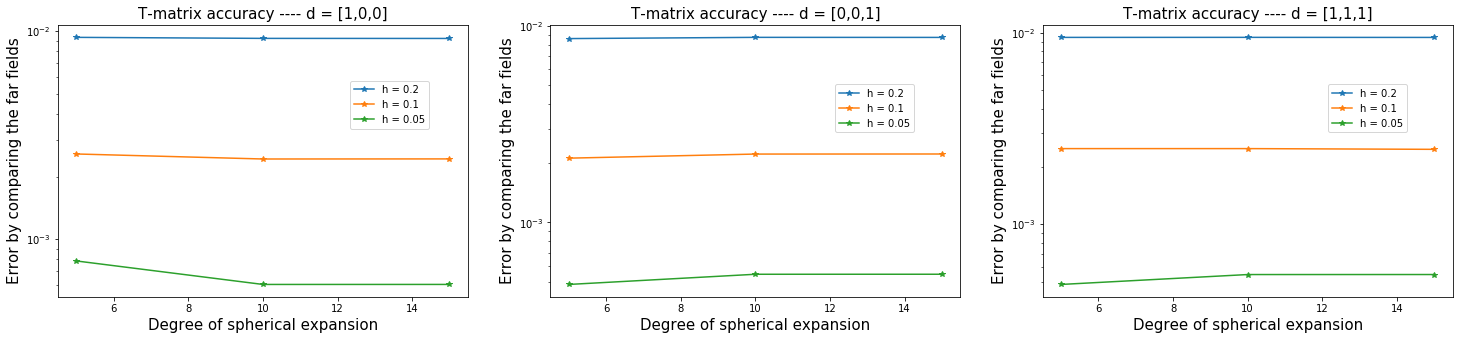

In [3]:
fig = plt.figure()
plt.figure(figsize = (25,5))
plt.subplot(1,3,1)
plt.semilogy(x_axis,d1_02,'*-')
plt.semilogy(x_axis,d1_01,'*-')
plt.semilogy(x_axis,d1_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'],  bbox_to_anchor=(0.7,0.6))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [1,0,0]',fontsize = 15)

plt.subplot(1,3,2)
plt.semilogy(x_axis,d2_02,'*-')
plt.semilogy(x_axis,d2_01,'*-')
plt.semilogy(x_axis,d2_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'], bbox_to_anchor=(0.9,0.8))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [0,0,1]',fontsize = 15)

plt.subplot(1,3,3)
plt.semilogy(x_axis,d3_02,'*-')
plt.semilogy(x_axis,d3_01,'*-')
plt.semilogy(x_axis,d3_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'], bbox_to_anchor=(0.9,0.8))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [1,1,1]',fontsize = 15)
plt.savefig('eight items T matrix accuracy.pdf',bbox_inches='tight')